# 综合大作业

**第一步：爱奇艺《青春有你2》评论数据爬取**(参考链接：[https://www.iqiyi.com/v_19ryfkiv8w.html#curid=15068699100_9f9bab7e0d1e30c494622af777f4ba39](http://))
* 爬取任意一期正片视频下评论
* 评论条数不少于1000条

**第二步：词频统计并可视化展示**
* 数据预处理：清理清洗评论中特殊字符（如：@#￥%、emoji表情符）,清洗后结果存储为txt文档
* 中文分词：添加新增词（如：青你、奥利给、冲鸭），去除停用词（如：哦、因此、不然、也好、但是）
* 统计top10高频词
* 可视化展示高频词

**第三步：绘制词云**
* 根据词频生成词云
* 可选项-添加背景图片，根据背景图片轮廓生成词云 

**第四步：结合PaddleHub，对评论进行内容审核**



# 需要的配置和准备
* 中文分词需要jieba
* 词云绘制需要wordcloud
* 可视化展示中需要的中文字体
* 网上公开资源中找一个中文停用词表
* 根据分词结果自己制作新增词表
* 准备一张词云背景图（附加项，不做要求，可用hub抠图实现）
* paddlehub配置



In [ ]:
!pip install jieba
!pip install wordcloud

Looking in indexes: https://pypi.mirrors.ustc.edu.cn/simple/
Looking in indexes: https://pypi.mirrors.ustc.edu.cn/simple/


In [ ]:
# !pip install beautifulsoup4 -t ./external-libraries
# !pip install lxml -t ./external-libraries
import sys
sys.path.append('./external-libraries')

In [ ]:
# Linux系统默认字体文件路径
# !ls /usr/share/fonts/
# 查看系统可用的ttf格式中文字体
!fc-list :lang=zh | grep ".ttf"

/home/aistudio/.fonts/chinese.simhei.ttf: SimHei,黑体:style=Regular
/home/aistudio/.fonts/SimHei.ttf: SimHei,黑体:style=Regular


In [ ]:
# !wget https://mydueros.cdn.bcebos.com/font/simhei.ttf # 下载中文字体
#创建字体目录fonts
!mkdir -p .fonts
# 复制字体文件到该路径
!cp *.ttf .fonts/
!cp *.ttf /opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/
!ls .fonts/

chinese.simhei.ttf  SimHei.ttf


In [ ]:
!pip install --upgrade paddlehub

Looking in indexes: https://pypi.mirrors.ustc.edu.cn/simple/
Requirement already up-to-date: paddlehub in /opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages (1.6.2)


In [ ]:
!hub install emotion_detection_textcnn==1.1.0

[==================================================] 100.00%
Uncompress /home/aistudio/.paddlehub/tmp/tmprvvntf_n/emotion_detection_textcnn
[==================================================] 100.00%


In [ ]:
from __future__ import print_function
import requests
import json
import re #正则匹配
import time #时间处理模块
import jieba #中文分词
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator  #绘制词云模块
import paddlehub as hub
import pandas as pd
from bs4 import BeautifulSoup
from multiprocessing import Process,Manager,Value,Lock

In [ ]:
#根据content_id，获取评论
def getMovieinfo(content_id):
    page = 1
    headers = { 
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/67.0.3396.99 Safari/537.36'
    }
    upremaining = 0
    while upremaining!=1 :
        url = 'https://sns-comment.iqiyi.com/v3/comment/get_comments.action?agent_type=118&agent_version=9.11.5&authcookie=null&business_type=17&content_id='+content_id+'&hot_size=0&last_id=&page='+str(page)+'&page_size=40&types=time'
        response = requests.get(url,headers=headers)
        resjson = json.loads(response.text)
        upremaining = resjson['data']['upremaining']
        coms = resjson['data']['comments']
        for val in coms:
            if 'content' in val.keys():
                comments.append(val['content'])
        page+=1
#获取视频列表    
def getMovies():
    content_ids=[]
    url = 'https://www.iqiyi.com/v_19ryi480ks.html'
    headers = { 
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/67.0.3396.99 Safari/537.36'
    }
    
    response = requests.get(url,headers=headers)
    soup = BeautifulSoup(response.text,'lxml')
    li = soup.find_all('li',{'class':'play-list-item'})
    for x in li:
        content_ids.append(x['data-td'])
    return content_ids[1:] #去除第一个预告片
#解析json数据，获取评论
def saveMovieInfoToFile():
    content_ids= getMovies()
    process= []
    for c_id in content_ids:
        # 每个进程爬取一个视频下的评论
        p = Process(target=getMovieinfo,args=(c_id,))
        process.append(p)
        p.start()
    
    #等待所有线程任务结束。
    for p in process:
        p.join()
    print("总共获取了",len(comments),'条评论')

In [ ]:
#去除文本中特殊字符
def clear_special_char():
    global comments
    '''
    正则处理特殊字符
    参数 content:原文本
    return: 清除后的文本
    '''

    import re
    from string import digits, punctuation
    for i in range(len(comments)):
        s = comments[i]
        # print(i)
        # print(s)
        rule = re.compile(u'[^a-zA-Z.,;《》？！“”‘’@#￥%…&×（）——+【】{};；●，。&～、|\s:：' + digits + punctuation + '\u4e00-\u9fa5]+')
        s = re.sub(rule, '', s)
        s = re.sub('[、]+', '，', s)
        s = re.sub('\'', '', s)
        s = re.sub('[#]+', '，', s)
        s = re.sub('[?]+', '？', s)
        s = re.sub('[;]+', '，', s)
        s = re.sub('[,]+', '，', s)
        s = re.sub('[!]+', '！', s)
        s = re.sub('[！]+', '！', s)
        s = re.sub('[？]+', '？', s)
        s = re.sub('[.]+', '.', s)
        s = re.sub('[，]+', '，', s)
        s = re.sub('[。]+', '。', s)
        s = re.sub('/([?!.])\1+/', '$1', s)
        # 人名去重
        for name in names:
            s = re.sub('('+name+')+',name,s)
        # 去除表情
        s = re.sub(r"\[\S+\]", "", s)
        comments[i] = s
    return


In [ ]:
def fenci(text):
    '''
    利用jieba进行分词
    参数 text:需要分词的句子或文本
    return：分词结果
    '''
    jieba.load_userdict('name.txt')
    seg = jieba.lcut(text,cut_all=False)
    return seg


In [ ]:
def stopwordslist(file_path):
    '''
    创建停用词表
    参数 file_path:停用词文本路径
    return：停用词list
    '''
    stopwords = [line.strip() for line in open(file_path, encoding="UTF-8").readlines()]
    return stopwords

In [ ]:
def movestopwords(sentence, stopwords, counts):
    '''
    去除停用词,统计词频
    参数 file_path:停用词文本路径 stopwords:停用词list counts: 词频统计结果
    return：None
    '''
    for word in sentence:
        if word not in stopwords:
            if len(word) > 1:
                counts[word] = counts.get(word, 0) + 1
    return None
    

In [45]:
def drawcounts(counts,num):
    '''
    绘制词频统计表
    参数 counts: 词频统计结果 num:绘制topN
    return：none
    '''
    sort_counts =  sorted(counts.items(), key=lambda kv: kv[1], reverse=True)
    x = []
    y = []
    count = 0
    for s in sort_counts:
        if s[0] in names:#筛选选手名
            x.append(s[0])
            y.append(s[1])
            count+=1
        if count == num:
            break

    matplotlib.rcParams['font.sans-serif'] = ['SimHei']
    matplotlib.rcParams['axes.unicode_minus'] = False
    from matplotlib.font_manager import _rebuild
    _rebuild() #reload一下
    plt.figure(figsize=(10, 10))
    plt.barh(x, y)
    plt.title('青春有你2 选手词频统计')
    plt.show()
    return
    

In [ ]:
def drawcloud(word_f):
    '''
    根据词频绘制词云图
    参数 word_f:统计出的词频结果
    return：none
    '''
    wc = WordCloud(random_state=42,width=800,height=400, relative_scaling=0.3, font_path='SimHei.ttf',background_color='white')

    # generate word cloud
    wc.fit_words(word_f)


    plt.figure(figsize=(10, 12))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()    
    wc.to_file('wordcloud.png')

In [49]:
def text_detection():
    '''
    使用hub对评论进行内容分析
    return：分析结果

    '''

    module = hub.Module(name="emotion_detection_textcnn")
    
    test_text = list(comments)
    input_dict = {"text": test_text}
    results = module.emotion_classify(data=input_dict)

    for result in results:
            if result['emotion_key']=='positive':
                positive.append(result['text'])
            elif result['emotion_key']=='neutral':
                neutral.append(result['text'])
            elif result['emotion_key']=='negative':
                negative.append(result['text'])
def draw_pie():
    labels = ["正向",'中性','负面']
    plt.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体
    matplotlib.rcParams.update({'font.size': 16})
    plt.figure(figsize=(12, 12))
    plt.pie([len(positive),len(neutral),len(negative)], explode=(0.1,0.1,0.1),labels=labels, shadow=True,autopct='%.2f%%',startangle=90)
    plt.axis('equal')
    plt.legend(loc="upper right",fontsize=10,bbox_to_anchor=(1.1,1.05),borderaxespad=0.3)
    plt.title('''《青春有你2》评价分析''',fontsize = 20)
    plt.savefig('pie.jpg')

In [ ]:
#评论是多分页的，得多次请求爱奇艺的评论接口才能获取多页评论,有些评论含有表情、特殊字符之类的
comments = Manager().list()
counts ={}
names = [line.strip() for line in open('name.txt', encoding="UTF-8").readlines()]
lock = Lock()
if __name__ == "__main__":
    saveMovieInfoToFile()

In [ ]:
comments = list(comments)
with open('output.txt', 'w') as file:  # Use file to refer to the file object
    json.dump(comments, file)

In [ ]:
with open('output.txt', 'r') as file:  # Use file to refer to the file object
        comments = json.load(file)
clear_special_char()

In [ ]:
# comments = tuple(comments)
stopwords = stopwordslist('cn_stopwords.txt')
i = 1
for comment in comments:
    sentence = fenci(comment)
    movestopwords(sentence, stopwords, counts)
    if i%10000 == 0:
        print(i)
    i+=1

In [ ]:
drawcounts(counts,20)

In [ ]:
print(len(comments))

254285


In [ ]:
drawcloud(counts)

In [35]:
positive = []
neutral = []
negative = []
text_detection()

[2020-04-30 09:25:33,002] [    INFO] - Installing emotion_detection_textcnn module
[2020-04-30 09:25:33,005] [    INFO] - Module emotion_detection_textcnn already installed in /home/aistudio/.paddlehub/modules/emotion_detection_textcnn
[2020-04-30 09:25:33,338] [    INFO] - Installing lac module
[2020-04-30 09:25:33,340] [    INFO] - Module lac already installed in /home/aistudio/.paddlehub/modules/lac


58200
183488
12597


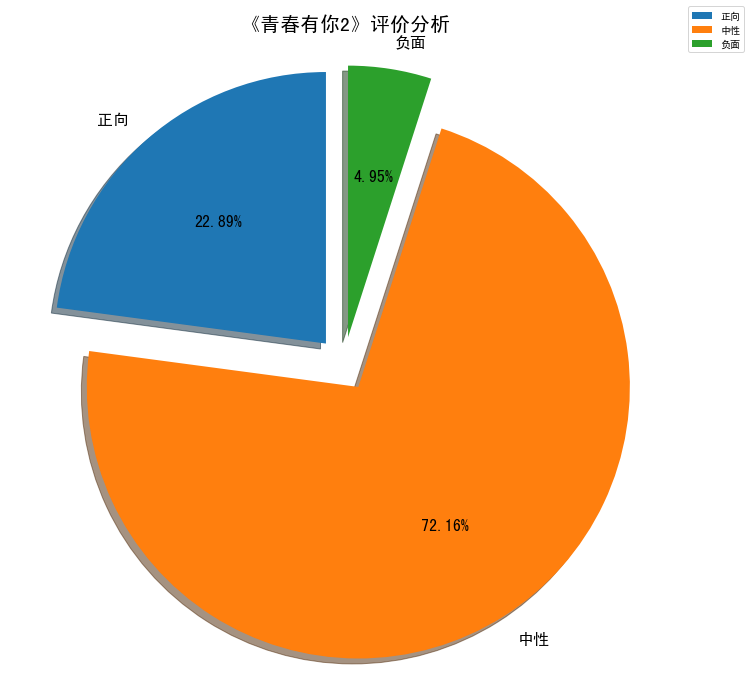

In [50]:
draw_pie()

In [52]:
print(positive[:10])
print(neutral[:10])
print(negative[:10])

['因为看了书欣的电视剧才来看这个的，喜欢她的性格', '我也喜欢左卓', '好喜欢刘雨昕！', '我真的太爱刘雨昕了', '好看好看', '看了这期，真的很心疼喻言', '安崎反差萌真的绝了，好看的颜值和有趣的灵魂她都拥有。', '我也喜欢虞书欣', '虞书欣加油', '冲着虞书欣搞笑视频来的，后面发现太太太多想pick的了。这种模式是看的第一个，努力又融洽的氛围真好。']
['乃万！', '乃万', '我要去看男团了拜拜，记得给我点赞', '大家要帮忙投票了吗我这儿还有13票', '大家有要帮忙投票的吗我还有14', '虞书欣', '乃万简直是可盐可甜可rap 可vocal， 随时写词的到处撩妹的博爱艺术家 。', '谢可寅小姐姐要加油喽。', '刘雨昕', '林凡']
['刘雨昕你咋不是个男的啊太帅了', '看得累死了磨磨叽叽', '我爱死所有训练生了', '傅如乔 爱死你了', '我就是看美女跳舞的，谁是谁，这个真不关心，长的都挺好看的，挺养眼', '看看徐紫茵吧，看孩子吧！她真的是个宝藏！入股不亏', '赵小棠什么鬼哦！', '真失望  为什么不是刘雨欣！  突然不想看了', '不要脸', '小蝴蝶胡馨尹很棒，呜呜呜不好意思之前没有发现你，不管在哪里都要继续加油呀！真的很棒！']
